In [21]:
from fastapi import FastAPI, Request, HTTPException, Form
from fastapi.templating import Jinja2Templates
from pydantic import BaseModel
import uvicorn
from transformers import AutoTokenizer, AutoModelForCausalLM
import os
from dotenv import load_dotenv
import cohere
from langchain_cohere import ChatCohere
from langchain_core.prompts import ChatPromptTemplate
import utils
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
load_dotenv()
#We get the trial API key of the Cohere LLM from the environment variables
trial_api_key = os.getenv("COHERE_TRIAL_API_KEY")

if not trial_api_key:
     raise ValueError("The API key is not defined in the environment variables.")

#We start the Cohere client
client = cohere.Client(
  api_key=trial_api_key 
) 

In [23]:
popcornai_instance = utils.aws_instance_connection()
cursor = popcornai_instance.cursor()
cursor.execute('''USE popcornai_db''')

0

In [24]:
cursor.execute('SHOW TABLES')
cursor.fetchall()

[{'Tables_in_popcornai_db': 'user_query_recommendation'}]

In [25]:
cursor.execute('''
                SELECT *
               FROM user_query_recommendation
               ''')
table = cursor.fetchall()
table

[{'id': 1,
  'user_query': 'Quiero ver una serie parecida a Stranger Things pero con menos temporadas y capítulos más cortos',
  'query_timestamp': datetime.datetime(2024, 12, 1, 14, 44, 9),
  'recommendation': '¡Hola! Una excelente opción que podría encajar con tu solicitud es la serie "Dark" de Netflix. Aunque tiene un tono un poco más oscuro y complejo que "Stranger Things", comparte muchos elementos similares que podrían gustarte.\n\n**Dark** es una serie alemana de ciencia ficción que cuenta la historia de la desaparición de dos niños en un pequeño pueblo llamado Winden. La serie explora temas de viajes en el tiempo, realidades paralelas y secretos familiares, creando una atmósfera misteriosa y enigmática.\n\nA diferencia de "Stranger Things", "Dark" tiene solo 3 temporadas, con un total de 26 episodios, y cada episodio dura aproximadamente 45-50 minutos, lo que hace que los capítulos sean un poco más cortos en comparación. La serie está cuidadosamente elaborada, con una trama com

In [26]:
df = pd.DataFrame(table)
df = df.set_index("id")

In [27]:
df

,user_query,query_timestamp,recommendation,recommendation_timestamp,answer_time,ip_adress
id,,,,,,
1,Quiero ver una serie parecida a Stranger Thing...,2024-12-01 14:44:09,¡Hola! Una excelente opción que podría encajar...,2024-12-01 14:44:17,7.281100,127.0.0.1
2,Quiero ver una película de dibujos animados cu...,2024-12-01 14:54:00,¡Por supuesto! Una película animada que encaja...,2024-12-01 14:54:06,6.159510,127.0.0.1
3,Quiero ver un musical que además sea educativo...,2024-12-01 14:55:30,¡Una excelente elección! Los musicales pueden ...,2024-12-01 14:55:41,10.971600,127.0.0.1
4,"Me gustaría ver una película actual, que sea d...",2024-12-01 14:56:55,¡Por supuesto! Una película que cumple con tus...,2024-12-01 14:57:01,5.593730,127.0.0.1
5,Quiero ver una serie similar a Perdidos pero m...,2024-12-01 15:10:44,There has been an internal failure,2024-12-01 15:10:44,0.000000,127.0.0.1
...,...,...,...,...,...,...
71,I want to watch a Spanish series similar to St...,2024-12-02 20:34:52,Great choice! If you enjoyed *Stranger Things*...,2024-12-02 20:34:57,4.377050,127.0.0.1
72,,2024-12-02 20:37:43,"Empty query. Please, include some details in o...",2024-12-02 20:37:44,0.799810,127.0.0.1
73,I want to watch a Spanish series similar to St...,2024-12-02 20:37:49,Great choice! If you enjoyed *Stranger Things*...,2024-12-02 20:37:53,4.200680,127.0.0.1


In [28]:
df[df["answer_time"] == 0]

,user_query,query_timestamp,recommendation,recommendation_timestamp,answer_time,ip_adress
id,,,,,,
5,Quiero ver una serie similar a Perdidos pero m...,2024-12-01 15:10:44,There has been an internal failure,2024-12-01 15:10:44,0.0,127.0.0.1


In [29]:
df["answer_time"].describe() #Our application takes, on average, 5 seconds to give a recommendation

count    75.000000
mean      5.627827
std       3.519028
min       0.000000
25%       2.815690
50%       5.071950
75%       8.081400
max      14.394700
Name: answer_time, dtype: float64

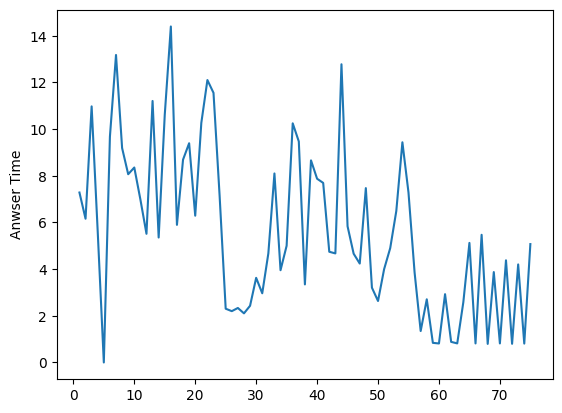

In [30]:
plt.plot(df["answer_time"])
plt.ylabel("Anwser Time")
plt.show()

In [31]:
df[(df["answer_time"] >= 0) & (df["answer_time"]<=1)]

,user_query,query_timestamp,recommendation,recommendation_timestamp,answer_time,ip_adress
id,,,,,,
5,Quiero ver una serie similar a Perdidos pero m...,2024-12-01 15:10:44,There has been an internal failure,2024-12-01 15:10:44,0.000000,127.0.0.1
59,\r\n,2024-12-02 19:25:17,"Empty query. Please, include some details abou...",2024-12-02 19:25:18,0.840826,127.0.0.1
60,,2024-12-02 19:25:27,"Empty query. Please, include some details abou...",2024-12-02 19:25:28,0.814266,127.0.0.1
62,,2024-12-02 19:43:56,"Empty query. Please, include some details abou...",2024-12-02 19:43:57,0.882857,127.0.0.1
63,\r\n,2024-12-02 19:44:05,"Empty query. Please, include some details abou...",2024-12-02 19:44:06,0.817406,127.0.0.1
66,,2024-12-02 20:25:04,"Empty query. Please, include some details in o...",2024-12-02 20:25:05,0.815710,127.0.0.1
68,,2024-12-02 20:29:50,"Empty query. Please, include some details in o...",2024-12-02 20:29:51,0.796342,127.0.0.1
70,,2024-12-02 20:34:49,"Empty query. Please, include some details in o...",2024-12-02 20:34:50,0.815994,127.0.0.1
72,,2024-12-02 20:37:43,"Empty query. Please, include some details in o...",2024-12-02 20:37:44,0.799810,127.0.0.1


In [33]:
df[(df["answer_time"] >= 1) & (df["answer_time"]<=4)]

,user_query,query_timestamp,recommendation,recommendation_timestamp,answer_time,ip_adress
id,,,,,,
25,Patatas,2024-12-02 16:06:30,"I'm sorry, I couldn't find any film or series ...",2024-12-02 16:06:32,2.30361,127.0.0.1
26,Patatas,2024-12-02 16:08:53,"I'm sorry, I don't understand your request. Co...",2024-12-02 16:08:55,2.19853,127.0.0.1
27,Patatas,2024-12-02 16:08:56,"I'm sorry, I don't have any recommendations fo...",2024-12-02 16:08:58,2.33498,127.0.0.1
28,Patatas,2024-12-02 16:10:28,"I'm sorry, I don't have any recommendations fo...",2024-12-02 16:10:31,2.10448,127.0.0.1
29,Pelo,2024-12-02 16:11:25,"Hello! I'm sorry, but I need more information ...",2024-12-02 16:11:27,2.42908,127.0.0.1
30,Chips,2024-12-02 16:41:39,If you're looking for something fun and light-...,2024-12-02 16:41:43,3.62606,127.0.0.1
31,Chips,2024-12-02 16:42:24,"If you're looking for a comedy film, I'd recom...",2024-12-02 16:42:26,2.96430,127.0.0.1
34,I want to watch a romantic series whose charac...,2024-12-02 17:00:34,"Well, the 80s was a great decade for teen roma...",2024-12-02 17:00:38,3.95349,127.0.0.1
38,A serie with Zac Efron,2024-12-02 17:14:26,Thanks for your request! If you are looking fo...,2024-12-02 17:14:30,3.34419,127.0.0.1


In [32]:
popcornai_instance.close()